In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import random
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from sklearn.neighbors import KNeighborsClassifier
import pickle
from tqdm import tqdm
import utils2 as util
import visualization as vis

import pandas as pd
import glob
from sklearn.decomposition import PCA
import data_generator as dataset
import os 
from sknetwork.clustering import Louvain
from sklearn.neighbors import kneighbors_graph
import scanpy_modified as scanpy
from anndata import AnnData
import scanpy as sp
import cProfile
from pstats import SortKey

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Generation

In [ ]:
REPEAT = 1 #why not

df = []
for i in tqdm(range(REPEAT)):
    sim = dataset.gen_cluster(num=np.random.randint(500, 1500), seed=i)
    df.append(sim)

for i in tqdm(range(REPEAT)):
    sim = dataset.gen_trajectory(num=np.random.randint(500,1500),seed=i)
    df.append(sim)

for i in tqdm(range(REPEAT)):
    np.random.seed(i)
    sim, ind = dataset.gen_random(num=np.random.randint(500,1500),mode=dataset.genType.CLUSTER,seed=i)
    df.append(sim)

for i in tqdm(range(REPEAT)):
    np.random.seed(i)
    sim, ind = dataset.gen_random(num=np.random.randint(500,1500),mode=dataset.genType.TRAJECTORY,seed=i)
    df.append(sim)
    
os.makedirs('scatterplots', exist_ok=True)
ct=0
for a in tqdm(df):
    ct += 1
    fig = plt.figure(figsize=(1.5, 1.5))
    plt.scatter(a[:, 0], a[:, 1], s=1)
    plt.savefig(f'scatterplots/{ct}.png')
    plt.close()

ORIGINAL_META_SCORES = []
OUR_META_SCORES = []
with cProfile.Profile() as pr:
    for df in tqdm(df):
        score = vis.our_scoring(df)
        OUR_META_SCORES.append(score)
        
    pr.print_stats(sort=SortKey.CUMULATIVE)
# for np_data in tqdm(df):
#     score2 = vis.original_scoring(np_data)
#     ORIGINAL_META_SCORES.append(score2)
# save the scores
os.makedirs('data', exist_ok=True)

# np.save('data/original_meta_scores.npy', np.array(ORIGINAL_META_SCORES))
# np.save('data/our_meta_scores.npy', np.array(OUR_META_SCORES))

100%|██████████| 1/1 [00:00<00:00, 1547.14it/s]


100%|██████████| 4/4 [00:26<00:00,  6.53s/it]

         42443117 function calls (42139069 primitive calls) in 26.119 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   121576    1.181    0.000    9.518    0.000 validation.py:718(check_array)
  2129811    1.059    0.000    1.390    0.000 _array_api.py:372(__getattr__)
6161118/6161062    0.987    0.000    1.480    0.000 {built-in method builtins.isinstance}
   121576    0.956    0.000    3.772    0.000 validation.py:93(_assert_all_finite)
   678756    0.934    0.000    0.934    0.000 {built-in method numpy.asarray}
    62888    0.861    0.000    2.681    0.000 pairwise.py:375(_euclidean_distances)
    60808    0.833    0.000    2.488    0.000 inspect.py:2397(_signature_from_function)
121536/60768    0.738    0.000   23.764    0.000 _param_validation.py:182(wrapper)
   668928    0.633    0.000    1.457    0.000 _param_validation.py:101(make_constraint)
    60768    0.604    0.000    0.917    0.000 inspect.py:3133(_bind)
  

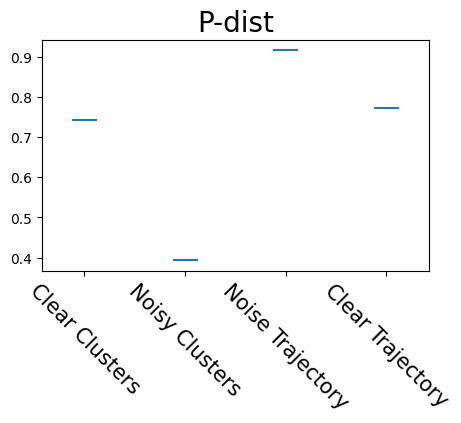

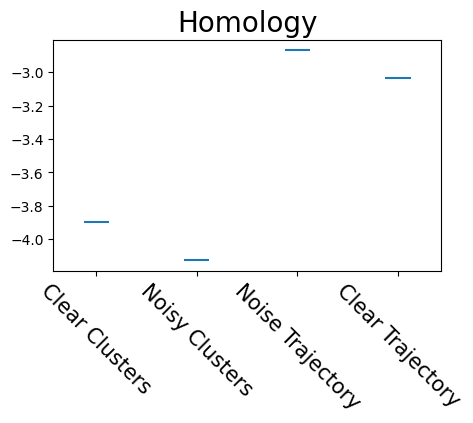

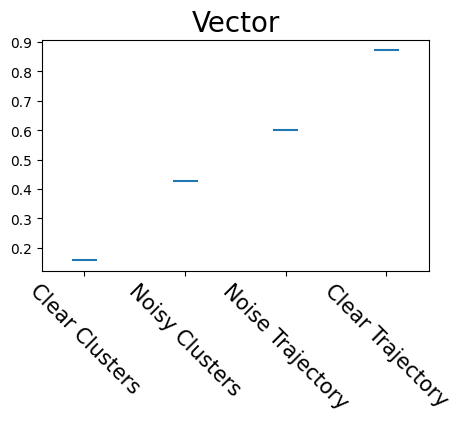

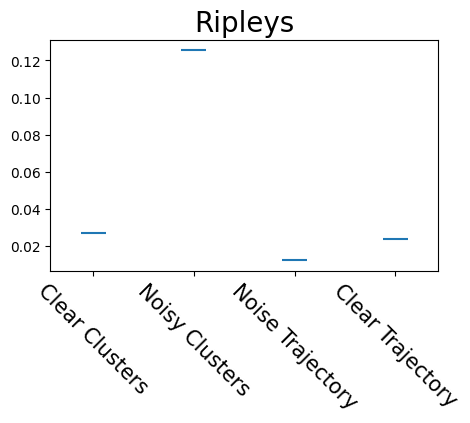

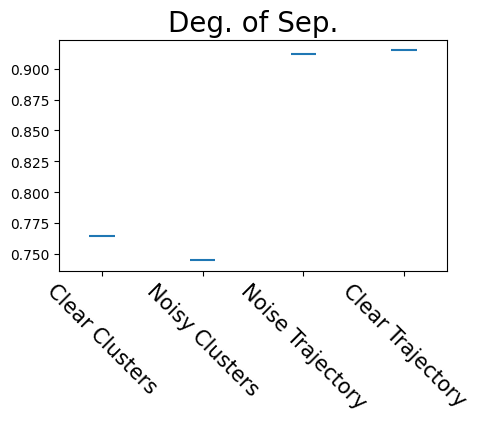

In [22]:
META_SCORES = list(np.load('data/our_meta_scores.npy')) # Loading pre-computed scores for simulated datasets

clstr = META_SCORES[:REPEAT]
traj = META_SCORES[REPEAT:2*REPEAT]
clstr_r1 = META_SCORES[2*REPEAT:3*REPEAT]
traj_r1 = META_SCORES[3*REPEAT:4*REPEAT]

npy_sim = np.array(META_SCORES)
feature_names = ['P-dist','Homology','Vector','Ripleys','Deg. of Sep.']
for i in range(len(feature_names)):
    feat = i
    plt.figure(figsize=(5,3))
    plt.violinplot([np.array(clstr)[:,feat],
                    np.array(clstr_r1)[:,feat],
                    np.array(traj_r1)[:,feat],
                    np.array(traj)[:,feat]],
                  showmeans = True, showextrema=False)
    plt.title(feature_names[i], fontsize = 20)
    plt.xticks(fontsize=15, rotation=315)
    plt.xticks([1, 2, 3, 4], ['Clear Clusters','Noisy Clusters','Noise Trajectory','Clear Trajectory'])
    plt.show()